Testing on validation set track ID: NRrbDxBR_1
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step
(90, 6144)


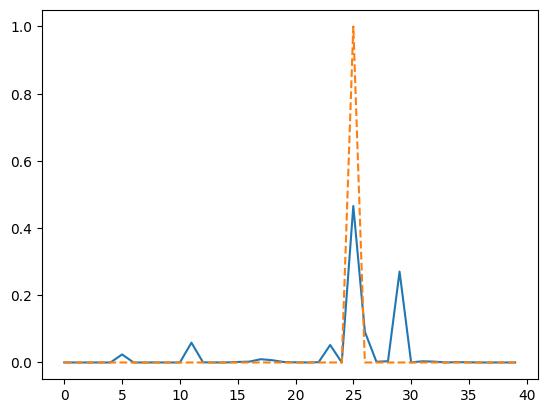

Predicted Mark: 85, Actual Mark: 85


In [1]:
import soundfile as sf
import torch
import numpy as np
import openl3
from combined_model import combined_model
import matplotlib.pyplot as plt

def create_song_embedding(file_path):
    audio, sr = sf.read(file_path)  # waveform and sampling rate
    # Get embedding
    emb, ts = openl3.get_audio_embedding(audio, sr, hop_size=1.0)
    print(emb.shape)
    return emb

def load_model(model, checkpoint_path):
    #Model Paramaters
    spec_size = 1500
    dim = 64
    drop = 0.15
    in_channels_class = 128
    model = combined_model(drop)
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    return model

def load_labels(label_path):
    labels = np.load(label_path, allow_pickle=True)
    return labels

def load_val_set_track_ids(path):
    return np.load(path, allow_pickle=True).tolist()

def load_grade_dict(path):
    grades = np.load(path, allow_pickle=True)
    return grades

def test(model, filepath):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = load_model(model, '/Users/acw707/Documents/abrsm-challenge-2025/model/checkpoints/best_model.pt')
    model.to(device)
    emb = create_song_embedding(filepath)
    emb = torch.tensor(emb).to(device)  # Add batch dimension
    emb = emb.mean(axis=0).unsqueeze(0)
    grades = load_grade_dict('/Users/acw707/Documents/abrsm_lmth25/data/grade_dict.npz')
    grade = grades[filepath.split('/')[-1][:-4]] 
    emb = torch.cat((emb, torch.tensor(grade, dtype=torch.float32).to(device).unsqueeze(0)), dim=1)
    with torch.no_grad():
        output = model(emb)
        predicted_mark = output.argmax(dim=1).item() + 60
    labels = load_labels('/Users/acw707/Documents/abrsm_lmth25/data/mark_dict.npz')
    label = labels[filepath.split('/')[-1][:-4]]
    softmax_output = torch.nn.functional.softmax(output, dim=1)
    plt.plot(softmax_output.cpu().numpy().squeeze())
    plt.plot(label, linestyle='dashed')
    plt.show()
    actual_mark = label.argmax() + 60
    print(f'Predicted Mark: {predicted_mark}, Actual Mark: {actual_mark}')
    return predicted_mark, actual_mark

val_track_ids = load_val_set_track_ids('/Users/acw707/Documents/abrsm-challenge-2025/model/checkpoints/val_set_track_ids.npy')
correct_within_0 = 0
correct_within_1 = 0
correct_within_2 = 0
correct_within_3 = 0
correct_within_4 = 0
correct_within_5 = 0
total = len(val_track_ids)
running_total = 0
for song in val_track_ids:
    if running_total != 1:
        running_total += 1
        continue
    print(f'Testing on validation set track ID: {song}')
    predicted_mark, actual_mark = test(combined_model, f'/Users/acw707/Documents/abrsm_lmth25/audio/{song}.mp3')
    if abs(predicted_mark - actual_mark) <= 5:
        correct_within_5 += 1
    if abs(predicted_mark - actual_mark) <= 4:
        correct_within_4 += 1
    if abs(predicted_mark - actual_mark) <= 3:
        correct_within_3 += 1
    if abs(predicted_mark - actual_mark) <= 2:
        correct_within_2 += 1
    if abs(predicted_mark - actual_mark) <= 1:
        correct_within_1 += 1
    if abs(predicted_mark - actual_mark) == 0:
        correct_within_0 += 1   
    running_total += 1
    break
    print(f'Current Accuracy within 0: {correct_within_0}/{running_total} = {correct_within_0/running_total}')
    print(f'Current Accuracy within 1: {correct_within_1}/{running_total} = {correct_within_1/running_total}')
    print(f'Current Accuracy within 2: {correct_within_2}/{running_total} = {correct_within_2/running_total}')
    print(f'Current Accuracy within 3: {correct_within_3}/{running_total} = {correct_within_3/running_total}')
    print(f'Current Accuracy within 4: {correct_within_4}/{running_total} = {correct_within_4/running_total}')
    print(f'Current Accuracy within 5: {correct_within_5}/{running_total} = {correct_within_5/running_total}')
